<a href="https://colab.research.google.com/github/wlg100/numseqcont_circuit_expms/blob/main/nb_templates/circuit_expms_template.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" align="left"/></a>&nbsp;or in a local notebook.

This will save files to your local machine if `save_files` is set to True.

# Setup

In [ ]:
%%capture
%pip install git+https://github.com/neelnanda-io/TransformerLens.git

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from fancy_einsum import einsum
import tqdm.notebook as tqdm
import random
from pathlib import Path
# import plotly.express as px
from torch.utils.data import DataLoader

from jaxtyping import Float, Int
from typing import List, Union, Optional
from functools import partial
import copy

import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML

import pickle
from google.colab import files

import matplotlib.pyplot as plt
import statistics

In [ ]:
import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache

We turn automatic differentiation off, to save GPU memory, as this notebook focuses on model inference not model training.

In [ ]:
torch.set_grad_enabled(False)

In [ ]:
save_files = True

# Load Model

In [ ]:
from transformers import LlamaForCausalLM, LlamaTokenizer

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
LLAMA_2_7B_CHAT_PATH = "meta-llama/Llama-2-7b-chat-hf"

tokenizer = LlamaTokenizer.from_pretrained(LLAMA_2_7B_CHAT_PATH)
# tokenizer = LlamaTokenizer.from_pretrained(LLAMA_2_7B_CHAT_PATH, use_fast= False, add_prefix_space= False)
hf_model = LlamaForCausalLM.from_pretrained(LLAMA_2_7B_CHAT_PATH, low_cpu_mem_usage=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

In [ ]:
import transformer_lens.utils as utils
from transformer_lens.hook_points import HookPoint
from transformer_lens import HookedTransformer

In [ ]:
model = HookedTransformer.from_pretrained(
    LLAMA_2_7B_CHAT_PATH,
    hf_model = hf_model,
    tokenizer = tokenizer,
    device = "cpu",
    fold_ln = False,
    center_writing_weights = False,
    center_unembed = False,
)

del hf_model

model = model.to("cuda" if torch.cuda.is_available() else "cpu")

Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer
Moving model to device:  cuda


# Test prompts

In [ ]:
# Get list of arguments to pass to `generate` (specifically these are the ones relating to sampling)
generate_kwargs = dict(
    do_sample = False, # deterministic output so we can compare it to the HF model
    top_p = 1.0, # suppresses annoying output errors
    temperature = 1.0, # suppresses annoying output errors
)

prompt =  "4 * 2 = "
output = model.generate(prompt, max_new_tokens=1, **generate_kwargs)
print(output)

  0%|          | 0/1 [00:00<?, ?it/s]

4 * 2 = 8


In [ ]:
prompt =  "3 * 3 = "
output = model.generate(prompt, max_new_tokens=1, **generate_kwargs)
print(output)

  0%|          | 0/1 [00:00<?, ?it/s]

3 * 3 = 9


In [ ]:
tokenizer.tokenize("4 * 2 = ")

['▁', '4', '▁*', '▁', '2', '▁=', '▁']

# Import functions from repo

In [ ]:
!git clone https://github.com/apartresearch/seqcont_circuits.git
%cd /content/seqcont_circuits/src/iter_node_pruning

Cloning into 'seqcont_circuits'...
remote: Enumerating objects: 909, done.
remote: Counting objects: 100% (375/375), done.
remote: Compressing objects: 100% (243/243), done.
remote: Total 909 (delta 208), reused 284 (delta 121), pack-reused 534
Receiving objects: 100% (909/909), 17.08 MiB | 15.09 MiB/s, done.
Resolving deltas: 100% (571/571), done.
/content/seqcont_circuits/src/iter_node_pruning


In [ ]:
# from dataset import Dataset
# from metrics import *

# the fns below will import dataset and metrics anyways, so run the new vers of them in next sections
from head_ablation_fns import *
from mlp_ablation_fns import *
from node_ablation_fns import *
from loop_node_ablation_fns import *

## redefine logit diff to use last tok

In [ ]:
def get_logit_diff(logits: Float[Tensor, "batch seq d_vocab"], dataset: Dataset, per_prompt=False):
    '''
    '''
    corr_logits: Float[Tensor, "batch"] = logits[range(logits.size(0)), -1, dataset.corr_tokenIDs]
    incorr_logits: Float[Tensor, "batch"] = logits[range(logits.size(0)), -1, dataset.incorr_tokenIDs]
    answer_logit_diff = corr_logits - incorr_logits
    return answer_logit_diff if per_prompt else answer_logit_diff.mean()

## redefine dataset to not pad first tok

In [ ]:
class Dataset:
    def __init__(self, prompts, tokenizer):  # , S1_is_first=False
        self.prompts = prompts
        self.tokenizer = tokenizer
        self.N = len(prompts)
        self.max_len = max(
            [
                len(self.tokenizer(prompt["text"]).input_ids[1:])
                for prompt in self.prompts
            ]
        )
        all_ids = [0 for prompt in self.prompts] # only 1 template
        all_ids_ar = np.array(all_ids)
        self.groups = []
        for id in list(set(all_ids)):
            self.groups.append(np.where(all_ids_ar == id)[0])

        texts = [ prompt["text"] for prompt in self.prompts ]
        self.toks = torch.Tensor(self.tokenizer(texts, padding=True).input_ids).type(
            torch.int
        )[:, 1:]
        self.corr_tokenIDs = [
            # self.tokenizer.encode(" " + prompt["corr"])[0] for prompt in self.prompts
            self.tokenizer.encode(prompt["corr"])[-1] for prompt in self.prompts
        ]
        self.incorr_tokenIDs = [
            # self.tokenizer.encode(" " + prompt["incorr"])[0] for prompt in self.prompts
            self.tokenizer.encode(prompt["incorr"])[-1] for prompt in self.prompts
        ]

        pos_dict = {}
        list_tokens = tokenizer.tokenize(prompts[0]["text"])
        for i, tok_as_str in enumerate(list_tokens):
            pos_dict['S'+str(i)] = i

        # word_idx: for every prompt, find the token index of each target token and "end"
        # word_idx is a tensor with an element for each prompt. The element is the targ token's ind at that prompt
        self.word_idx = {}
        # for targ in [key for key in self.prompts[0].keys() if (key != 'text' and key != 'corr' and key != 'incorr')]:
        for targ in [key for key in pos_dict]:
            targ_lst = []
            for prompt in self.prompts:
                input_text = prompt["text"]
                # tokens = self.tokenizer.tokenize(input_text)
                target_index = pos_dict[targ]
                targ_lst.append(target_index)
            self.word_idx[targ] = torch.tensor(targ_lst)

        targ_lst = []
        for prompt in self.prompts:
            input_text = prompt["text"]
            tokens = self.tokenizer.tokenize(input_text)
            end_token_index = len(tokens) - 1
            targ_lst.append(end_token_index)
        self.word_idx["end"] = torch.tensor(targ_lst)

    def __len__(self):
        return self.N

# Load datasets

Because llama-2 tokenizer treats space as a token, remember to ablate even the spaces too, not just the numbers!

In [ ]:
import random

def make_clean_and_corrupt_prompts():
    prompts_list = [
        {'corr': '6', 'incorr': '5', 'text': '2 * 3 = '},
        {'corr': '8', 'incorr': '6', 'text': '4 * 2 = '},
        {'corr': '3', 'incorr': '4', 'text': '3 * 1 = '},
        {'corr': '9', 'incorr': '6', 'text': '3 * 3 = '},
    ]
    corrupted_prompts_list = [
        {'corr': '6', 'incorr': '5', 'text': '2 + 3 = '},
        {'corr': '8', 'incorr': '6', 'text': '4 + 2 = '},
        {'corr': '3', 'incorr': '4', 'text': '3 + 1 = '},
        {'corr': '9', 'incorr': '6', 'text': '3 + 3 = '},
    ]

    # for _ in range(5):  # Generate 10 random single-digit addition problems
    for i in range(len(prompts_list)):
        prompt_dict = prompts_list[i]
        corrupted_prompt_dict = corrupted_prompts_list[i]

        # a = random.randint(1, 3)  # Restrict to ensure the product is a single digit
        # b = random.randint(1, 3)
        # while a * b >= 10:
        #     a = random.randint(1, 3)
        #     b = random.randint(1, 3)
        # correct_answer = str(a * b)
        # text = f"{a} * {b} = "

        # c = random.randint(1, 3)  # Restrict to ensure the product is a single digit
        # d = random.randint(1, 3)
        # while c * d >= 10:
        #     c = random.randint(1, 3)
        #     d = random.randint(1, 3)
        # incorrect_answer = str(c * d)
        # corrupted_text = f"{c} * {d} = "

        # prompt_dict = {
        #     'corr': correct_answer,
        #     'incorr': incorrect_answer,
        #     'text': text
        # }
        # corrupted_prompt_dict = {
        #     'corr': correct_answer,
        #     'incorr': incorrect_answer,
        #     'text': corrupted_text
        # }

        list_tokens = model.tokenizer.tokenize(prompt_dict['text'])
        for i, tok_as_str in enumerate(list_tokens):
            prompt_dict['S'+str(i)] = tok_as_str
        # prompts_list.append(prompt_dict)

        list_tokens = model.tokenizer.tokenize(corrupted_prompt_dict['text'])
        for i, tok_as_str in enumerate(list_tokens):
            corrupted_prompt_dict['S'+str(i)] = tok_as_str
        # corrupted_prompts_list.append(corrupted_prompt_dict)

    return prompts_list, corrupted_prompts_list

# Generate prompts
prompts_list, prompts_list_2 = make_clean_and_corrupt_prompts()
for prompt in prompts_list:
    print(prompt)

{'corr': '6', 'incorr': '5', 'text': '2 * 3 = ', 'S0': '▁', 'S1': '2', 'S2': '▁*', 'S3': '▁', 'S4': '3', 'S5': '▁=', 'S6': '▁'}
{'corr': '8', 'incorr': '6', 'text': '4 * 2 = ', 'S0': '▁', 'S1': '4', 'S2': '▁*', 'S3': '▁', 'S4': '2', 'S5': '▁=', 'S6': '▁'}
{'corr': '3', 'incorr': '4', 'text': '3 * 1 = ', 'S0': '▁', 'S1': '3', 'S2': '▁*', 'S3': '▁', 'S4': '1', 'S5': '▁=', 'S6': '▁'}
{'corr': '9', 'incorr': '6', 'text': '3 * 3 = ', 'S0': '▁', 'S1': '3', 'S2': '▁*', 'S3': '▁', 'S4': '3', 'S5': '▁=', 'S6': '▁'}


In [ ]:
for prompt in prompts_list_2:
    print(prompt)

{'corr': '6', 'incorr': '5', 'text': '2 + 3 = ', 'S0': '▁', 'S1': '2', 'S2': '▁+', 'S3': '▁', 'S4': '3', 'S5': '▁=', 'S6': '▁'}
{'corr': '8', 'incorr': '6', 'text': '4 + 2 = ', 'S0': '▁', 'S1': '4', 'S2': '▁+', 'S3': '▁', 'S4': '2', 'S5': '▁=', 'S6': '▁'}
{'corr': '3', 'incorr': '4', 'text': '3 + 1 = ', 'S0': '▁', 'S1': '3', 'S2': '▁+', 'S3': '▁', 'S4': '1', 'S5': '▁=', 'S6': '▁'}
{'corr': '9', 'incorr': '6', 'text': '3 + 3 = ', 'S0': '▁', 'S1': '3', 'S2': '▁+', 'S3': '▁', 'S4': '3', 'S5': '▁=', 'S6': '▁'}


In [ ]:
dataset = Dataset(prompts_list, model.tokenizer)
dataset.toks.shape

torch.Size([4, 7])

In [ ]:
dataset_2 = Dataset(prompts_list_2, model.tokenizer)
dataset_2.toks.shape

torch.Size([4, 7])

# Get orig score

In [ ]:
model.reset_hooks(including_permanent=True)
logits_original = model(dataset.toks)
orig_score = get_logit_diff(logits_original, dataset)

In [ ]:
next_token = logits_original[0, -1].argmax(dim=-1)  # logits have shape [1, sequence_length, vocab_size]
next_char = model.to_string(next_token)
print(repr(next_char))

'6'


In [ ]:
orig_score

tensor(5.9062, device='cuda:0')

In [ ]:
import gc

del(logits_original)
torch.cuda.empty_cache()
gc.collect()

0

# Find Impt Attention Heads from Full

## test unablated run

Llama-2 has 32 heads per layer

In [ ]:
lst = [(layer, head) for layer in range(32) for head in range(0, 32)]
CIRCUIT = {}
SEQ_POS_TO_KEEP = {}

list_tokens = tokenizer.tokenize(dataset.prompts[0]['text'])
for i, tok_as_str in enumerate(list_tokens):
    CIRCUIT['S'+str(i)] = lst
    SEQ_POS_TO_KEEP['S'+str(i)] = 'S'+str(i)
    # if i == 5:
    #     SEQ_POS_TO_KEEP['S'+str(i)] = 'end'
# for i in range(1, 4):
#     CIRCUIT['S'+str(i)] = lst
#     # if i == 3:
#     #     SEQ_POS_TO_KEEP['S'+str(i)] = 'end'
#     # else:
#     SEQ_POS_TO_KEEP['S'+str(i)] = 'S'+str(i)
SEQ_POS_TO_KEEP

{'S0': 'S0',
 'S1': 'S1',
 'S2': 'S2',
 'S3': 'S3',
 'S4': 'S4',
 'S5': 'S5',
 'S6': 'S6'}

In [ ]:
model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook

model = add_ablation_hook_head(model, means_dataset=dataset_2, circuit=CIRCUIT, seq_pos_to_keep=SEQ_POS_TO_KEEP)
logits_ablated = model(dataset.toks)

new_score = get_logit_diff(logits_ablated, dataset)

In [ ]:
next_token = logits_ablated[0, -1].argmax(dim=-1)  # logits have shape [1, sequence_length, vocab_size]
next_char = model.to_string(next_token)
print(repr(next_char))

'6'


In [ ]:
print(f"Average logit difference (circuit / full) %: {100 * new_score / orig_score:.4f}")
new_score

Average logit difference (circuit / full) %: 100.0000


tensor(5.9062, device='cuda:0')

In [ ]:
import gc

del(logits_ablated)
torch.cuda.empty_cache()
gc.collect()

0

## run each

In [ ]:
def ablate_head_from_full(
        lst: List[Tuple[int, int]],
        model: HookedTransformer,
        dataset: Dataset,
        dataset_2: Dataset,
        orig_score: float,
        print_output: bool = True,
) -> float:
    # CIRCUIT contains the components to not ablate
    CIRCUIT = {}
    SEQ_POS_TO_KEEP = {}

    list_tokens = tokenizer.tokenize('uno cinco cuatro tres')
    for i, tok_as_str in enumerate(list_tokens):
        CIRCUIT['S'+str(i)] = lst
        SEQ_POS_TO_KEEP['S'+str(i)] = 'S'+str(i)
        if i == 5:
            SEQ_POS_TO_KEEP['S'+str(i)] = 'end'

    model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook

    model = add_ablation_hook_head(model, means_dataset=dataset_2, circuit=CIRCUIT, seq_pos_to_keep=SEQ_POS_TO_KEEP)
    logits_minimal = model(dataset.toks)

    new_score = get_logit_diff(logits_minimal, dataset)
    if print_output:
        print(f"Average logit difference (circuit / full) %: {100 * new_score / orig_score:.4f}")
    return 100 * new_score / orig_score

In [ ]:
circ = [(layer, head) for layer in range(32) for head in range(0, 32)]
# to_loop = circ.copy() # (L,H) to remove
to_loop = [(layer, head) for layer in range(32) for head in range(0, 32)]

lh_scores = {}
for lh in to_loop:
    copy_circuit = circ.copy()
    copy_circuit.remove(lh)
    print("removed: " + str(lh))
    new_score = ablate_head_from_full(copy_circuit, model, dataset, dataset_2, orig_score, print_output=True).item()
    lh_scores[lh] = new_score

removed: (0, 0)
Average logit difference (circuit / full) %: 94.5032
removed: (0, 1)
Average logit difference (circuit / full) %: 101.6958
removed: (0, 2)
Average logit difference (circuit / full) %: 95.2070
removed: (0, 3)
Average logit difference (circuit / full) %: 97.4410
removed: (0, 4)
Average logit difference (circuit / full) %: 127.3183
removed: (0, 5)
Average logit difference (circuit / full) %: 98.9918
removed: (0, 6)
Average logit difference (circuit / full) %: 111.5740
removed: (0, 7)
Average logit difference (circuit / full) %: 93.4445
removed: (0, 8)
Average logit difference (circuit / full) %: 102.6469
removed: (0, 9)
Average logit difference (circuit / full) %: 94.1874
removed: (0, 10)
Average logit difference (circuit / full) %: 100.4389
removed: (0, 11)
Average logit difference (circuit / full) %: 99.4862
removed: (0, 12)
Average logit difference (circuit / full) %: 96.9849
removed: (0, 13)
Average logit difference (circuit / full) %: 74.5288
removed: (0, 14)
Average 

In [ ]:
# Sort the dictionary by values in descending order
sorted_lh_scores = sorted(lh_scores.items(), key=lambda item: -item[1], reverse=True)

# Iterate over the top 10 items and print them
i=1
for lh, score in sorted_lh_scores[:50]:
    modified_score = -round(100 - score, 2)
    print(i, lh, modified_score)
    i+=1

1 (20, 17) -97.17
2 (22, 25) -53.88
3 (16, 0) -45.06
4 (0, 15) -40.83
5 (6, 14) -37.37
6 (29, 5) -31.53
7 (18, 9) -29.6
8 (7, 30) -29.42
9 (0, 13) -25.47
10 (15, 25) -23.07
11 (0, 21) -19.85
12 (5, 26) -16.59
13 (18, 31) -15.24
14 (0, 31) -14.19
15 (1, 8) -13.66
16 (4, 7) -13.07
17 (3, 7) -10.66
18 (0, 14) -10.39
19 (2, 22) -10.29
20 (23, 2) -10.22
21 (0, 25) -10.09
22 (5, 24) -9.81
23 (8, 0) -8.39
24 (0, 27) -8.08
25 (1, 21) -7.84
26 (16, 29) -7.79
27 (2, 17) -7.33
28 (7, 1) -7.05
29 (26, 28) -6.87
30 (19, 11) -6.73
31 (0, 7) -6.56
32 (4, 3) -6.54
33 (16, 28) -6.37
34 (7, 7) -6.25
35 (7, 0) -5.94
36 (5, 15) -5.84
37 (28, 30) -5.82
38 (0, 9) -5.81
39 (10, 23) -5.69
40 (22, 29) -5.63
41 (30, 27) -5.59
42 (0, 0) -5.5
43 (4, 10) -5.44
44 (24, 28) -4.93
45 (8, 10) -4.81
46 (13, 24) -4.8
47 (10, 17) -4.8
48 (0, 2) -4.79
49 (6, 19) -4.76
50 (1, 12) -4.73


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

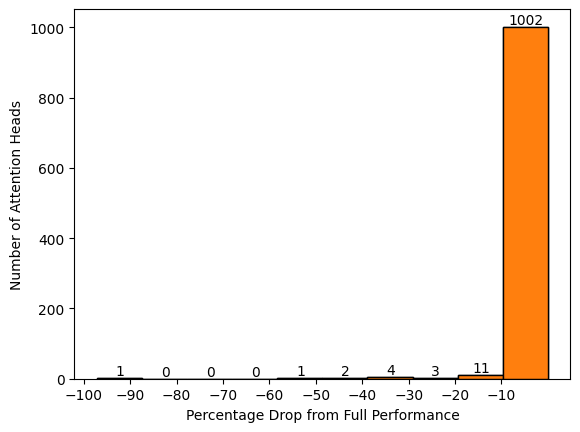

In [ ]:
lh_scores_drop = {key: min(0, val-100) for key, val in lh_scores.items()}
scores = list(lh_scores_drop.values())
plt.hist(scores, bins=10, edgecolor='black')
n, bins, patches = plt.hist(scores, bins=10, edgecolor='black')  # Adjust the number of bins as needed

# Annotating the histogram with the number of values in each bin
for i in range(len(n)):
    plt.text(bins[i]+5, n[i], str(int(n[i])), va='bottom', ha='center')

plt.xticks(range(-100, 0, 10))
plt.xlabel('Percentage Drop from Full Performance')
plt.ylabel('Number of Attention Heads')
# plt.title('Distribution of Attention Head Performance Drop Percentages')

# plt.show()

if save_files:
    pdf_filename = 'lh_scores_distribution.pdf'
    plt.savefig(pdf_filename)
    files.download(pdf_filename)

In [ ]:
scores = list(lh_scores_drop.values())
mean_score = statistics.mean(scores)
print("Mean of the scores:", mean_score)

if save_files:
    with open('numerals_lh_scores.pkl', 'wb') as file:
        pickle.dump(lh_scores, file)
        files.download('numerals_lh_scores.pkl')

Mean of the scores: -1.0899533543270081


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## plot heatmap

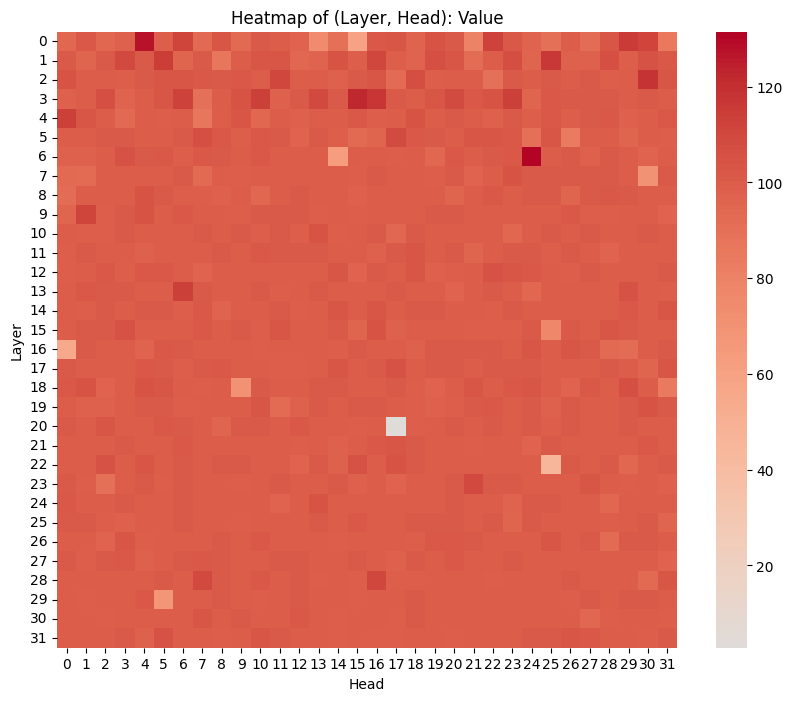

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert dictionary to a DataFrame
data_list = [(key[0], key[1], value) for key, value in lh_scores.items()]
df = pd.DataFrame(data_list, columns=['Layer', 'Head', 'Value'])

# Create a pivot table
pivot_table = df.pivot(index='Layer', columns='Head', values='Value').fillna(0)

# Plot the heatmap
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(pivot_table, cmap='coolwarm', center=0, annot=False, cbar=True)
plt.xlabel('Head')
plt.ylabel('Layer')
plt.title('Heatmap of (Layer, Head): Value')

# Rotate y-axis numbers to horizontal
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)

plt.show()

# Find Impt MLPs from Full

In [ ]:
for i in range(32):
    lst = [layer for layer in range(32) if layer != i]
    perc_of_orig = ablate_MLP_from_full(lst, model, dataset, dataset_2, orig_score, print_output=False).item()
    print(i, perc_of_orig)

0 120.2237777709961
1 112.8310317993164
2 150.87498474121094
3 87.185791015625
4 14.503439903259277
5 122.77428436279297
6 126.99913024902344
7 127.29161071777344
8 106.36880493164062
9 80.6562728881836
10 96.6606216430664
11 2.1473228931427
12 120.33763885498047
13 3.876375436782837
14 108.92326354980469
15 98.53825378417969
16 104.73899841308594
17 38.77589797973633
18 108.10041046142578
19 81.74701690673828
20 118.44805145263672
21 96.85259246826172
22 66.60285186767578
23 96.97480010986328
24 43.38495635986328
25 68.84285736083984
26 75.79950714111328
27 99.72819519042969
28 104.97547912597656
29 109.37677001953125
30 101.52474212646484
31 101.87178802490234


# Node Ablation- ablate_attnLayer_thenHeads

In [ ]:
model.cfg.n_layers

32

In [ ]:
model.cfg.n_heads

32

## new fns

In [ ]:
# from dataset import Dataset
# from transformer_lens import HookedTransformer, utils
# from transformer_lens.hook_points import HookPoint
# import einops
# from functools import partial
# import torch as t
# from torch import Tensor
# from typing import Dict, Tuple, List
# from jaxtyping import Float, Bool

# from node_ablation_fns import *

# def find_circuit_forw(model, dataset, dataset_2, heads_not_ablate=None, mlps_not_ablate=None, orig_score=100, threshold=10):
#     # threshold is T, a %. if performance is less than T%, allow its removal
#     # we don't ablate the curr circuits
#     if heads_not_ablate == []: # Start with full circuit
#         heads_not_ablate = [(layer, head) for layer in range(12) for head in range(12)]
#     if mlps_not_ablate == []:
#         mlps_not_ablate = [layer for layer in range(12)]

#     comp_scores = {}
#     for layer in range(0, 12):
#         for head in range(12):
#             print(layer, head)
#             if (layer, head) not in heads_not_ablate:
#                 continue

#             copy_heads_not_ablate = heads_not_ablate.copy()
#             copy_heads_not_ablate.remove((layer, head))

#             model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
#             ablated_model = add_ablation_hook_MLP_head(model, dataset_2, copy_heads_not_ablate, mlps_not_ablate)

#             new_logits = ablated_model(dataset.toks)
#             new_score = get_logit_diff(new_logits, dataset)
#             new_perc = 100 * new_score / orig_score
#             comp_scores[layer] = new_perc
#             print(f"(cand circuit / full) %: {new_perc:.4f}")
#             if (100 - new_perc) < threshold:
#                 heads_not_ablate.remove((layer, head))
#                 print("Removed:", (layer, head))
#             del(new_logits)

#         print(layer)
#         if layer in mlps_not_ablate:
#             copy_mlps_not_ablate = mlps_not_ablate.copy()
#             copy_mlps_not_ablate.remove(layer)

#             model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
#             ablated_model = add_ablation_hook_MLP_head(model, dataset_2, heads_not_ablate, copy_mlps_not_ablate)

#             new_logits = ablated_model(dataset.toks)
#             new_score = get_logit_diff(new_logits, dataset)
#             new_perc = 100 * new_score / orig_score
#             comp_scores[(layer, head)] = new_perc
#             print(f"(cand circuit / full) %: {new_perc:.4f}")
#             if (100 - new_perc) < threshold:
#                 mlps_not_ablate.remove(layer)
#                 print("Removed: MLP ", layer)
#             del(new_logits)

#     return heads_not_ablate, mlps_not_ablate, new_perc, comp_scores

def find_circ_backw_attnL_thenHeads(model, dataset, dataset_2, heads_not_ablate=None, mlps_not_ablate=None, orig_score=100, threshold=10):
    # threshold is T, a %. if performance is less than T%, allow its removal
    # we don't ablate the curr circuits
    if heads_not_ablate == []: # Start with full circuit
        heads_not_ablate = [(layer, head) for layer in range(model.cfg.n_layers) for head in range(model.cfg.n_heads)]
    if mlps_not_ablate == []:
        mlps_not_ablate = [layer for layer in range(model.cfg.n_layers)]

    comp_scores = {}
    for layer in range(model.cfg.n_layers -1, -1, -1):  # go thru all heads in a layer first
        # if layer == 9:
        #     break
        print(layer)
        if layer in mlps_not_ablate:
            copy_mlps_not_ablate = mlps_not_ablate.copy()
            copy_mlps_not_ablate.remove(layer)

            model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
            ablated_model = add_ablation_hook_MLP_head(model, dataset_2, heads_not_ablate, copy_mlps_not_ablate)

            new_logits = ablated_model(dataset.toks)
            new_score = get_logit_diff(new_logits, dataset)
            new_perc = 100 * new_score / orig_score
            comp_scores[layer] = new_perc
            print(f"(cand circuit MLP / full) %: {new_perc:.4f}")
            if (100 - new_perc) < threshold:
                mlps_not_ablate.remove(layer)
                print("Removed: MLP ", layer)
            del(new_logits)

        # try removing entire attnLayer first
        # ablate all heads, so rmv all heads of layer in this copy
        copy_heads_not_ablate = heads_not_ablate.copy()
        copy_heads_not_ablate = [(layer_copy, head) for layer_copy, head in copy_heads_not_ablate if layer_copy != layer]

        model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
        ablated_model = add_ablation_hook_MLP_head(model, dataset_2, copy_heads_not_ablate, mlps_not_ablate)

        new_logits = ablated_model(dataset.toks)
        new_score = get_logit_diff(new_logits, dataset)
        new_perc = 100 * new_score / orig_score
        print(f"(cand circuit AttnL / full) %: {new_perc:.4f}")
        if (100 - new_perc) < threshold:
            heads_not_ablate = [(layer_copy, head) for layer_copy, head in heads_not_ablate if layer_copy != layer]
            print("Removed All Heads in Attention Layer:", (layer))
        del(new_logits)

        if (100 - new_perc) < threshold:  # eg. new_perc is still 30, thres is 20, so "too close to 100"
            continue

        for head in range(model.cfg.n_heads):
            print(layer, head)
            if (layer, head) not in heads_not_ablate:
                continue

            copy_heads_not_ablate = heads_not_ablate.copy()
            copy_heads_not_ablate.remove((layer, head))

            model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
            ablated_model = add_ablation_hook_MLP_head(model, dataset_2, copy_heads_not_ablate, mlps_not_ablate)

            new_logits = ablated_model(dataset.toks)
            new_score = get_logit_diff(new_logits, dataset)
            new_perc = 100 * new_score / orig_score
            comp_scores[(layer, head)] = new_perc
            print(f"(cand circuit / full) %: {new_perc:.4f}")
            if (100 - new_perc) < threshold:
                heads_not_ablate.remove((layer, head))
                print("Removed:", (layer, head))
            del(new_logits)

    return heads_not_ablate, mlps_not_ablate, new_score, comp_scores

## run

In [ ]:
# threshold = 20
# curr_circ_heads = []
# curr_circ_mlps = []
# prev_score = 100
# new_score = 0
# iter = 1
# all_comp_scores = []
# while prev_score != new_score:
#     print('\nbackw prune, iter ', str(iter))
#     old_circ_heads = curr_circ_heads.copy() # save old before finding new one
#     old_circ_mlps = curr_circ_mlps.copy()
#     curr_circ_heads, curr_circ_mlps, new_score, comp_scores = find_circuit_backw(model, dataset, dataset_2, curr_circ_heads, curr_circ_mlps, orig_score, threshold)
#     if old_circ_heads == curr_circ_heads and old_circ_mlps == curr_circ_mlps:
#         break
#     all_comp_scores.append(comp_scores)
#     print('\nfwd prune, iter ', str(iter))
#     # track changes in circuit as for some reason it doesn't work with scores
#     old_circ_heads = curr_circ_heads.copy()
#     old_circ_mlps = curr_circ_mlps.copy()
#     curr_circ_heads, curr_circ_mlps, new_score, comp_scores = find_circuit_forw(model, dataset, dataset_2, curr_circ_heads, curr_circ_mlps, orig_score, threshold)
#     if old_circ_heads == curr_circ_heads and old_circ_mlps == curr_circ_mlps:
#         break
#     all_comp_scores.append(comp_scores)
#     iter += 1

In [52]:
threshold = 20
curr_circ_heads = []
curr_circ_mlps = []
prev_score = 100
new_score = 0
iter = 1
all_comp_scores = []
# while prev_score != new_score:
# print('\nbackw prune, iter ', str(iter))
old_circ_heads = curr_circ_heads.copy() # save old before finding new one
old_circ_mlps = curr_circ_mlps.copy()
curr_circ_heads, curr_circ_mlps, new_score, comp_scores = find_circ_backw_attnL_thenHeads(model, dataset, dataset_2, curr_circ_heads, curr_circ_mlps, orig_score, threshold)

32
(cand circuit AttnL / full) %: 100.0000
Removed All Heads in Attention Layer: 32
31
(cand circuit MLP / full) %: 80.8873
Removed: MLP  31
(cand circuit AttnL / full) %: 90.1262
Removed All Heads in Attention Layer: 31
30
(cand circuit MLP / full) %: 79.9119
(cand circuit AttnL / full) %: 89.6288
Removed All Heads in Attention Layer: 30
29
(cand circuit MLP / full) %: 79.7297
(cand circuit AttnL / full) %: 70.0561
29 0
(cand circuit / full) %: 89.6809
Removed: (29, 0)
29 1
(cand circuit / full) %: 89.5215
Removed: (29, 1)
29 2
(cand circuit / full) %: 89.4181
Removed: (29, 2)
29 3
(cand circuit / full) %: 89.4204
Removed: (29, 3)
29 4
(cand circuit / full) %: 89.4287
Removed: (29, 4)
29 5
(cand circuit / full) %: 68.4593
29 6
(cand circuit / full) %: 89.4324
Removed: (29, 6)
29 7
(cand circuit / full) %: 89.1981
Removed: (29, 7)
29 8
(cand circuit / full) %: 89.2078
Removed: (29, 8)
29 9
(cand circuit / full) %: 89.2073
Removed: (29, 9)
29 10
(cand circuit / full) %: 89.1392
Removed:

In [53]:
with open('singleDigitMultp_b_20_scores.pkl', 'wb') as file:
    pickle.dump(all_comp_scores, file)
files.download('singleDigitMultp_b_20_scores.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [54]:
curr_circ_heads

[(0, 2),
 (0, 7),
 (0, 12),
 (0, 13),
 (0, 14),
 (0, 15),
 (0, 21),
 (0, 25),
 (0, 29),
 (0, 30),
 (1, 1),
 (1, 18),
 (1, 19),
 (1, 20),
 (1, 22),
 (1, 30),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 5),
 (2, 7),
 (2, 12),
 (2, 13),
 (2, 18),
 (2, 19),
 (2, 20),
 (2, 22),
 (2, 23),
 (2, 24),
 (2, 28),
 (3, 2),
 (3, 13),
 (3, 15),
 (3, 16),
 (3, 24),
 (3, 27),
 (3, 29),
 (4, 0),
 (4, 3),
 (5, 0),
 (5, 2),
 (5, 9),
 (5, 15),
 (5, 16),
 (5, 24),
 (5, 26),
 (5, 28),
 (6, 3),
 (6, 4),
 (6, 5),
 (6, 7),
 (6, 11),
 (6, 14),
 (6, 15),
 (6, 18),
 (6, 19),
 (6, 22),
 (6, 23),
 (6, 24),
 (6, 25),
 (6, 31),
 (7, 8),
 (7, 13),
 (7, 18),
 (7, 19),
 (7, 24),
 (7, 30),
 (8, 0),
 (8, 1),
 (8, 2),
 (8, 16),
 (8, 29),
 (8, 30),
 (9, 2),
 (9, 5),
 (9, 6),
 (9, 7),
 (9, 9),
 (9, 10),
 (9, 31),
 (10, 5),
 (10, 6),
 (12, 22),
 (13, 1),
 (13, 2),
 (13, 6),
 (13, 11),
 (13, 14),
 (14, 2),
 (14, 19),
 (14, 24),
 (14, 27),
 (15, 5),
 (15, 9),
 (15, 15),
 (16, 0),
 (16, 2),
 (16, 4),
 (16, 5),
 (16, 7),
 (16, 8),
 (16, 9),


In [55]:
curr_circ_mlps

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 23,
 24,
 25,
 26,
 28,
 29,
 30]

## Find most impt heads from circ

In [56]:
model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
model = add_ablation_hook_MLP_head(model, dataset_2, curr_circ_heads, curr_circ_mlps)

new_logits = model(dataset.toks)
new_score = get_logit_diff(new_logits, dataset)
circ_score = (100 * new_score / orig_score).item()
print(f"(cand circuit / full) %: {circ_score:.4f}")

(cand circuit / full) %: 80.1700


In [57]:
lh_scores = {}
for lh in curr_circ_heads:
    copy_circuit = curr_circ_heads.copy()
    copy_circuit.remove(lh)
    print("removed: " + str(lh))
    model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
    model = add_ablation_hook_MLP_head(model, dataset_2, copy_circuit, curr_circ_mlps)

    new_logits = model(dataset.toks)
    new_score = get_logit_diff(new_logits, dataset).item()
    new_perc = 100 * new_score / orig_score
    print(f"(cand circuit / full) %: {new_perc:.4f}")
    lh_scores[lh] = new_perc

removed: (0, 2)
(cand circuit / full) %: 78.6561
removed: (0, 7)
(cand circuit / full) %: 80.1714
removed: (0, 12)
(cand circuit / full) %: 79.8698
removed: (0, 13)
(cand circuit / full) %: 73.6777
removed: (0, 14)
(cand circuit / full) %: 74.3628
removed: (0, 15)
(cand circuit / full) %: 70.3607
removed: (0, 21)
(cand circuit / full) %: 75.5321
removed: (0, 25)
(cand circuit / full) %: 77.0256
removed: (0, 29)
(cand circuit / full) %: 78.9021
removed: (0, 30)
(cand circuit / full) %: 79.8313
removed: (1, 1)
(cand circuit / full) %: 80.6963
removed: (1, 18)
(cand circuit / full) %: 79.7317
removed: (1, 19)
(cand circuit / full) %: 78.7895
removed: (1, 20)
(cand circuit / full) %: 79.6457
removed: (1, 22)
(cand circuit / full) %: 82.0441
removed: (1, 30)
(cand circuit / full) %: 79.8093
removed: (2, 0)
(cand circuit / full) %: 79.5419
removed: (2, 1)
(cand circuit / full) %: 80.0384
removed: (2, 2)
(cand circuit / full) %: 79.0666
removed: (2, 5)
(cand circuit / full) %: 70.6012
removed

In [58]:
sorted_lh_scores = dict(sorted(lh_scores.items(), key=lambda item: item[1]))
for lh, score in sorted_lh_scores.items():
    print(lh, -round(circ_score-score.item(), 2))

(12, 22) -52.31
(16, 0) -23.9
(17, 31) -22.0
(14, 19) -18.6
(22, 25) -18.55
(29, 5) -14.57
(6, 24) -12.24
(5, 26) -12.03
(21, 17) -9.9
(0, 15) -9.81
(2, 5) -9.57
(16, 27) -9.34
(19, 22) -8.8
(0, 13) -6.49
(0, 14) -5.81
(3, 13) -5.52
(13, 11) -5.43
(15, 15) -5.4
(18, 26) -5.2
(19, 6) -5.03
(0, 21) -4.64
(13, 14) -4.62
(5, 15) -4.55
(19, 10) -4.46
(3, 2) -4.11
(4, 0) -4.02
(9, 5) -3.96
(5, 2) -3.85
(10, 5) -3.72
(19, 11) -3.18
(10, 6) -3.17
(0, 25) -3.14
(18, 31) -3.11
(14, 2) -3.06
(16, 24) -3.04
(3, 16) -2.95
(20, 17) -2.37
(8, 0) -2.37
(14, 27) -2.26
(15, 5) -2.21
(5, 16) -2.18
(9, 2) -2.17
(7, 24) -2.11
(5, 24) -1.99
(6, 5) -1.93
(6, 14) -1.92
(7, 30) -1.84
(20, 16) -1.73
(4, 3) -1.68
(5, 9) -1.65
(0, 2) -1.51
(6, 11) -1.5
(2, 28) -1.47
(9, 31) -1.43
(1, 19) -1.38
(7, 18) -1.33
(3, 24) -1.3
(0, 29) -1.27
(6, 22) -1.21
(13, 6) -1.18
(6, 31) -1.17
(2, 2) -1.1
(2, 12) -1.09
(2, 18) -1.03
(6, 19) -1.02
(8, 1) -1.01
(2, 20) -0.95
(16, 5) -0.9
(7, 13) -0.86
(8, 16) -0.85
(15, 9) -0.83
(9, 

# Node Ablation Iteration

## new fns

In [ ]:
# from dataset import Dataset
# from transformer_lens import HookedTransformer, utils
# from transformer_lens.hook_points import HookPoint
# import einops
# from functools import partial
# import torch as t
# from torch import Tensor
# from typing import Dict, Tuple, List
# from jaxtyping import Float, Bool

# from node_ablation_fns import *

# def find_circuit_forw(model, dataset, dataset_2, heads_not_ablate=None, mlps_not_ablate=None, orig_score=100, threshold=10):
#     # threshold is T, a %. if performance is less than T%, allow its removal
#     # we don't ablate the curr circuits
#     if heads_not_ablate == []: # Start with full circuit
#         heads_not_ablate = [(layer, head) for layer in range(12) for head in range(12)]
#     if mlps_not_ablate == []:
#         mlps_not_ablate = [layer for layer in range(12)]

#     comp_scores = {}
#     for layer in range(0, 12):
#         for head in range(12):
#             print(layer, head)
#             if (layer, head) not in heads_not_ablate:
#                 continue

#             copy_heads_not_ablate = heads_not_ablate.copy()
#             copy_heads_not_ablate.remove((layer, head))

#             model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
#             ablated_model = add_ablation_hook_MLP_head(model, dataset_2, copy_heads_not_ablate, mlps_not_ablate)

#             new_logits = ablated_model(dataset.toks)
#             new_score = get_logit_diff(new_logits, dataset)
#             new_perc = 100 * new_score / orig_score
#             comp_scores[layer] = new_perc
#             print(f"(cand circuit / full) %: {new_perc:.4f}")
#             if (100 - new_perc) < threshold:
#                 heads_not_ablate.remove((layer, head))
#                 print("Removed:", (layer, head))
#             del(new_logits)

#         print(layer)
#         if layer in mlps_not_ablate:
#             copy_mlps_not_ablate = mlps_not_ablate.copy()
#             copy_mlps_not_ablate.remove(layer)

#             model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
#             ablated_model = add_ablation_hook_MLP_head(model, dataset_2, heads_not_ablate, copy_mlps_not_ablate)

#             new_logits = ablated_model(dataset.toks)
#             new_score = get_logit_diff(new_logits, dataset)
#             new_perc = 100 * new_score / orig_score
#             comp_scores[(layer, head)] = new_perc
#             print(f"(cand circuit / full) %: {new_perc:.4f}")
#             if (100 - new_perc) < threshold:
#                 mlps_not_ablate.remove(layer)
#                 print("Removed: MLP ", layer)
#             del(new_logits)

#     return heads_not_ablate, mlps_not_ablate, new_perc, comp_scores

def find_circuit_backw(model, dataset, dataset_2, heads_not_ablate=None, mlps_not_ablate=None, orig_score=100, threshold=10):
    # threshold is T, a %. if performance is less than T%, allow its removal
    # we don't ablate the curr circuits
    if heads_not_ablate == []: # Start with full circuit
        heads_not_ablate = [(layer, head) for layer in range(32) for head in range(32)]
    if mlps_not_ablate == []:
        mlps_not_ablate = [layer for layer in range(32)]

    comp_scores = {}
    for layer in range(31, -1, -1):  # go thru all heads in a layer first
        print(layer)
        if layer in mlps_not_ablate:
            copy_mlps_not_ablate = mlps_not_ablate.copy()
            copy_mlps_not_ablate.remove(layer)

            model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
            ablated_model = add_ablation_hook_MLP_head(model, dataset_2, heads_not_ablate, copy_mlps_not_ablate)

            new_logits = ablated_model(dataset.toks)
            new_score = get_logit_diff(new_logits, dataset)
            new_perc = 100 * new_score / orig_score
            comp_scores[layer] = new_perc
            print(f"(cand circuit / full) %: {new_perc:.4f}")
            if (100 - new_perc) < threshold:
                mlps_not_ablate.remove(layer)
                print("Removed: MLP ", layer)
            del(new_logits)

        for head in range(32):
            print(layer, head)
            if (layer, head) not in heads_not_ablate:
                continue

            copy_heads_not_ablate = heads_not_ablate.copy()
            copy_heads_not_ablate.remove((layer, head))

            model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
            ablated_model = add_ablation_hook_MLP_head(model, dataset_2, copy_heads_not_ablate, mlps_not_ablate)

            new_logits = ablated_model(dataset.toks)
            new_score = get_logit_diff(new_logits, dataset)
            new_perc = 100 * new_score / orig_score
            comp_scores[(layer, head)] = new_perc
            print(f"(cand circuit / full) %: {new_perc:.4f}")
            if (100 - new_perc) < threshold:
                heads_not_ablate.remove((layer, head))
                print("Removed:", (layer, head))
            del(new_logits)

    return heads_not_ablate, mlps_not_ablate, new_score, comp_scores

## run

In [ ]:
# threshold = 20
# curr_circ_heads = []
# curr_circ_mlps = []
# prev_score = 100
# new_score = 0
# iter = 1
# all_comp_scores = []
# while prev_score != new_score:
#     print('\nbackw prune, iter ', str(iter))
#     old_circ_heads = curr_circ_heads.copy() # save old before finding new one
#     old_circ_mlps = curr_circ_mlps.copy()
#     curr_circ_heads, curr_circ_mlps, new_score, comp_scores = find_circuit_backw(model, dataset, dataset_2, curr_circ_heads, curr_circ_mlps, orig_score, threshold)
#     if old_circ_heads == curr_circ_heads and old_circ_mlps == curr_circ_mlps:
#         break
#     all_comp_scores.append(comp_scores)
#     print('\nfwd prune, iter ', str(iter))
#     # track changes in circuit as for some reason it doesn't work with scores
#     old_circ_heads = curr_circ_heads.copy()
#     old_circ_mlps = curr_circ_mlps.copy()
#     curr_circ_heads, curr_circ_mlps, new_score, comp_scores = find_circuit_forw(model, dataset, dataset_2, curr_circ_heads, curr_circ_mlps, orig_score, threshold)
#     if old_circ_heads == curr_circ_heads and old_circ_mlps == curr_circ_mlps:
#         break
#     all_comp_scores.append(comp_scores)
#     iter += 1

In [ ]:
threshold = 20
curr_circ_heads = []
curr_circ_mlps = []
prev_score = 100
new_score = 0
iter = 1
all_comp_scores = []
# while prev_score != new_score:
# print('\nbackw prune, iter ', str(iter))
old_circ_heads = curr_circ_heads.copy() # save old before finding new one
old_circ_mlps = curr_circ_mlps.copy()
curr_circ_heads, curr_circ_mlps, new_score, comp_scores = find_circuit_backw(model, dataset, dataset_2, curr_circ_heads, curr_circ_mlps, orig_score, threshold)

31
(cand circuit / full) %: 83.1991
Removed: MLP  31
31 0
(cand circuit / full) %: 83.2084
Removed: (31, 0)
31 1
(cand circuit / full) %: 83.2129
Removed: (31, 1)
31 2
(cand circuit / full) %: 83.2106
Removed: (31, 2)
31 3
(cand circuit / full) %: 83.2079
Removed: (31, 3)
31 4
(cand circuit / full) %: 83.2134
Removed: (31, 4)
31 5
(cand circuit / full) %: 83.1482
Removed: (31, 5)
31 6
(cand circuit / full) %: 83.1502
Removed: (31, 6)
31 7
(cand circuit / full) %: 83.1504
Removed: (31, 7)
31 8
(cand circuit / full) %: 83.1548
Removed: (31, 8)
31 9


KeyboardInterrupt: 

In [ ]:
with open('singleDigitFibo_b_20_scores.pkl', 'wb') as file:
    pickle.dump(all_comp_scores, file)
files.download('singleDigitFibo_b_20_scores.pkl')

In [ ]:
curr_circ_heads

In [ ]:
curr_circ_mlps

## Find most impt heads from circ

In [ ]:
model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
model = add_ablation_hook_MLP_head(model, dataset_2, curr_circ_heads, curr_circ_mlps)

new_logits = model(dataset.toks)
new_score = get_logit_diff(new_logits, dataset)
circ_score = (100 * new_score / orig_score).item()
print(f"(cand circuit / full) %: {circ_score:.4f}")

In [ ]:
lh_scores = {}
for lh in curr_circ_heads:
    copy_circuit = curr_circ_heads.copy()
    copy_circuit.remove(lh)
    print("removed: " + str(lh))
    model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
    model = add_ablation_hook_MLP_head(model, dataset_2, copy_circuit, curr_circ_mlps)

    new_logits = model(dataset.toks)
    new_score = get_logit_diff(new_logits, dataset).item()
    new_perc = 100 * new_score / orig_score
    print(f"(cand circuit / full) %: {new_perc:.4f}")
    lh_scores[lh] = new_perc

In [ ]:
sorted_lh_scores = dict(sorted(lh_scores.items(), key=lambda item: item[1]))
for lh, score in sorted_lh_scores.items():
    print(lh, -round(circ_score-score.item(), 2))

# Run on other task's circuits

In [ ]:
heads_not_ablate = [(0, 1), (1, 5), (4, 4), (4, 10), (5, 0), (6, 1), (6, 6), (6, 10), (7, 11), (8, 1), (8, 6), (8, 8), (8, 9), (9, 1)]
mlps_not_ablate = [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11]

model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
model = add_ablation_hook_MLP_head(model, dataset_2, heads_not_ablate, mlps_not_ablate)

new_logits = model(dataset.toks)
new_score = get_logit_diff(new_logits, dataset)
circ_score = (100 * new_score / orig_score).item()
print(f"(cand circuit / full) %: {circ_score:.4f}")

(cand circuit / full) %: 81.0075


In [ ]:
# numwords
heads_not_ablate = [(0, 1), (1, 5), (4, 4), (4, 10), (5, 8), (6, 1), (6, 6), (6, 10), (7, 2), (7, 6), (7, 11), (8, 1), (8, 6), (8, 8), (8, 9), (8, 11), (9, 1), (9, 5), (9, 7)]
mlps_not_ablate = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
model = add_ablation_hook_MLP_head(model, dataset_2, heads_not_ablate, mlps_not_ablate)

new_logits = model(dataset.toks)
new_score = get_logit_diff(new_logits, dataset)
circ_score = (100 * new_score / orig_score).item()
print(f"(cand circuit / full) %: {circ_score:.4f}")

(cand circuit / full) %: 87.3488


In [ ]:
# months
heads_not_ablate = [(0, 1), (0, 5), (4, 4), (6, 1), (6, 6), (6, 10), (7, 6), (7, 9), (7, 10), (7, 11), (8, 8), (9, 1), (10, 7)]
mlps_not_ablate = [0, 1, 2, 3, 4, 6, 7, 8, 9, 10]

model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
model = add_ablation_hook_MLP_head(model, dataset_2, heads_not_ablate, mlps_not_ablate)

new_logits = model(dataset.toks)
new_score = get_logit_diff(new_logits, dataset)
circ_score = (100 * new_score / orig_score).item()
print(f"(cand circuit / full) %: {circ_score:.4f}")

(cand circuit / full) %: 43.7440


In [ ]:
CIRCUIT = {
    "name mover": [(9, 9), (10, 0), (9, 6)],
    "backup name mover": [(10, 10), (10, 6), (10, 2), (10, 1), (11, 2), (9, 7), (9, 0), (11, 9)],
    "negative name mover": [(10, 7), (11, 10)],
    "s2 inhibition": [(7, 3), (7, 9), (8, 6), (8, 10)],
    "induction": [(5, 5), (5, 8), (5, 9), (6, 9)],
    "duplicate token": [(0, 1), (0, 10), (3, 0)],
    "previous token": [(2, 2), (4, 11)],
}

import itertools
a = [val for val in CIRCUIT.values()]
IOI_heads = list(itertools.chain.from_iterable(a))

mlps_not_ablate = list(range(12))

model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
model = add_ablation_hook_MLP_head(model, dataset_2, IOI_heads, mlps_not_ablate)

new_logits = model(dataset.toks)
new_score = get_logit_diff(new_logits, dataset)
circ_score = (100 * new_score / orig_score).item()
print(f"(cand circuit / full) %: {circ_score:.4f}")

(cand circuit / full) %: -6.6992


In [ ]:
### months w/ MLP 11

heads_not_ablate = [(0, 1), (4, 4), (4, 10), (6, 1), (6, 6), (6, 10), (7, 2), (7, 10), (7, 11), (8, 8), (9, 1)]
mlps_not_ablate = [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11] # incl 5 makes it 66.1155%

model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
model = add_ablation_hook_MLP_head(model, dataset_2, heads_not_ablate, mlps_not_ablate)

new_logits = model(dataset.toks)
new_score = get_logit_diff(new_logits, dataset)
circ_score = (100 * new_score / orig_score).item()
print(f"(cand circuit / full) %: {circ_score:.4f}")

(cand circuit / full) %: 37.7001
